In [37]:
import pandas as pd
from rdkit import Chem

In [38]:
df_Shuzhe = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/df_original_shuze_standardized_298.csv')
df_opera = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/df_25_opera_standardized.csv')
df_reach_semi_curated_exp = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/sandbox/REACH_semi_curated_features_compact_298K.csv')
df_naef_acree = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/sandbox/NAEF_features_compact_298K.csv')
df_Shuzhe = df_Shuzhe.rename(columns={'VP_logPA_shuze': 'log10_VP_Pa'})
df_opera = df_opera.rename(columns={'VP logPa': 'log10_VP_Pa'})

In [39]:
#for all, just get the smiles, VP and inchikeys
df_Shuzhe_compact = df_Shuzhe[['standardized_smiles', 'log10_VP_Pa', 'inchikey']]
df_opera_compact = df_opera[['standardized_smiles', 'log10_VP_Pa', 'inchikey']]
df_reach_semi_curated_exp_compact = df_reach_semi_curated_exp[['standardized_smiles', 'log10_VP_Pa', 'inchikey']]
df_naef_acree_compact = df_naef_acree[['standardized_smiles', 'log10_VP_Pa', 'inchikey']]
#add column source
df_Shuzhe_compact['source'] = 'Shuzhe'
df_opera_compact['source'] = 'OPERA'
df_reach_semi_curated_exp_compact['source'] = 'REACH'
df_naef_acree_compact['source'] = 'Naef'

/tmp/ipykernel_16747/1838603239.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Shuzhe_compact['source'] = 'Shuzhe'
/tmp/ipykernel_16747/1838603239.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_opera_compact['source'] = 'OPERA'
/tmp/ipykernel_16747/1838603239.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

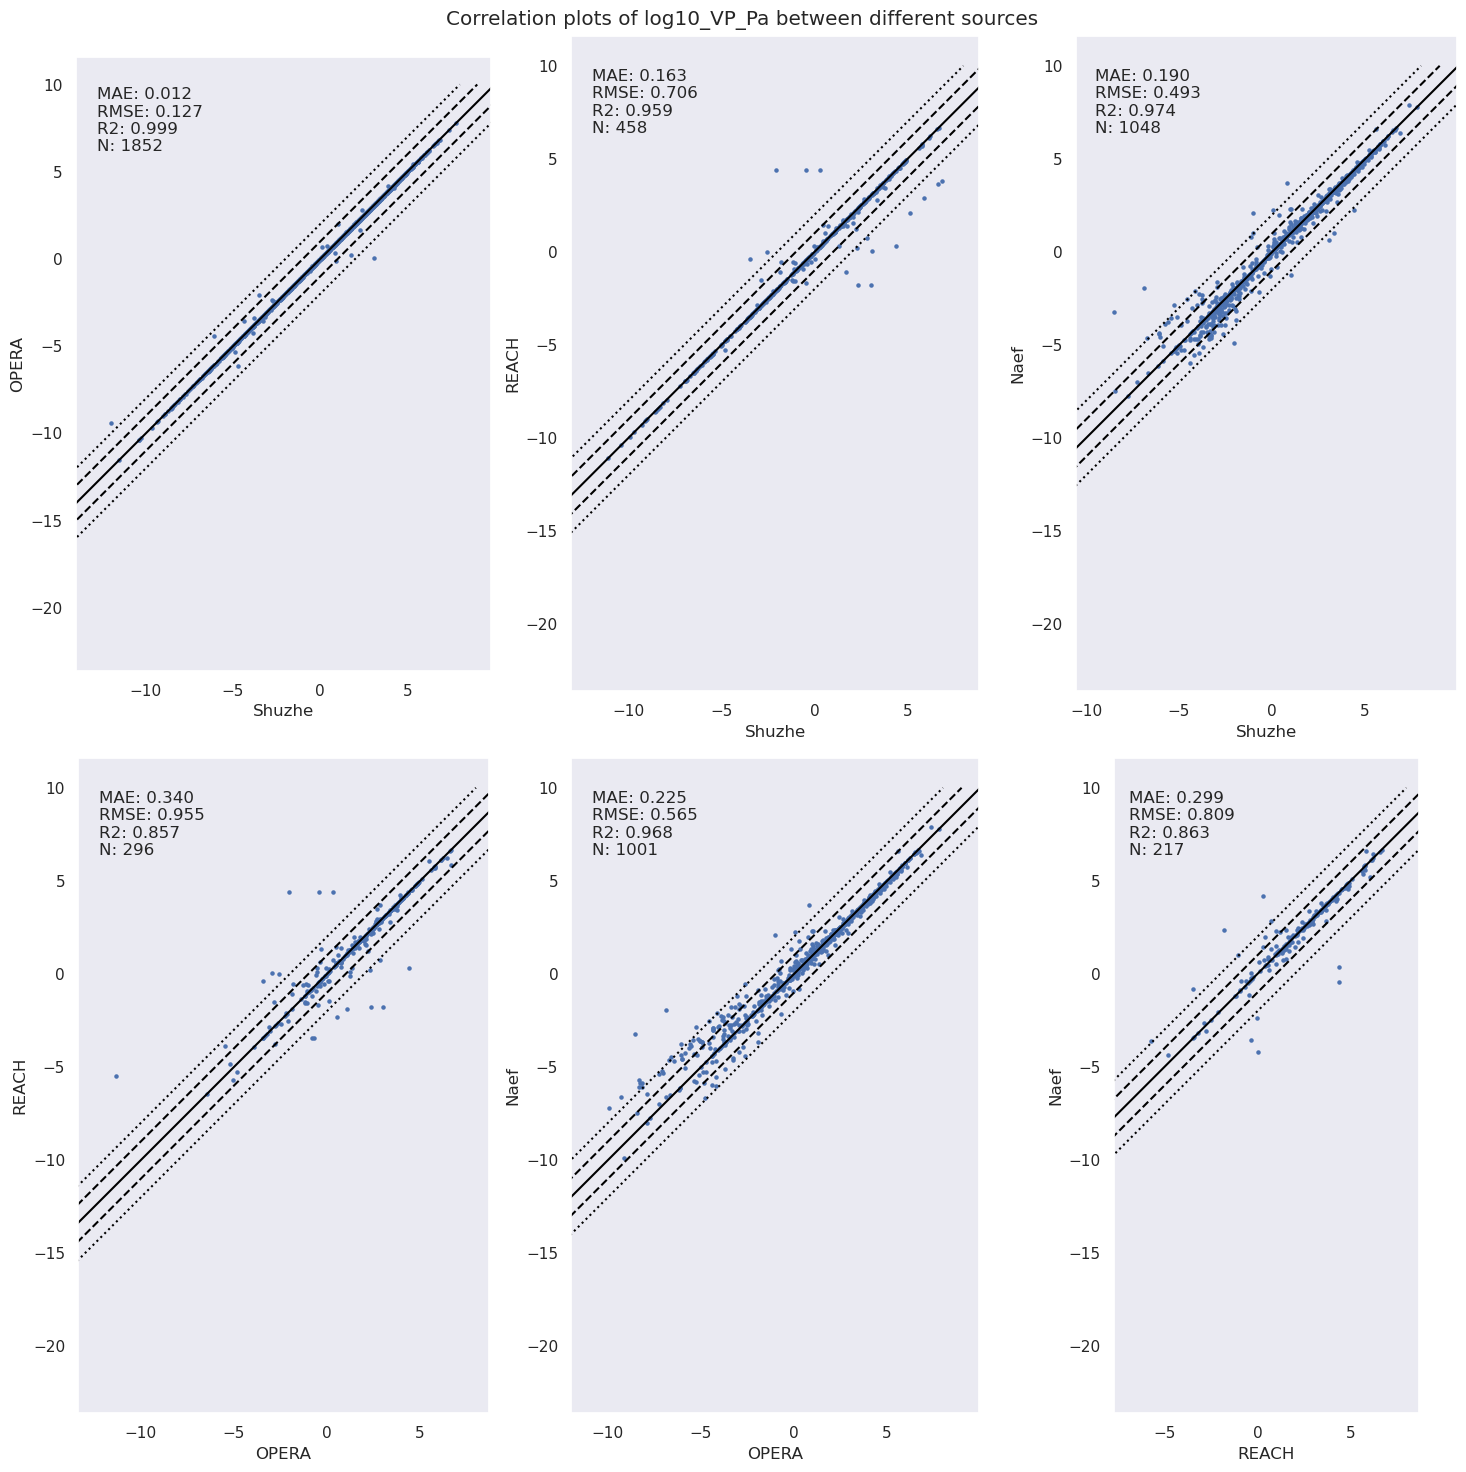

In [77]:
df_combined = pd.concat([df_Shuzhe_compact, df_opera_compact, df_reach_semi_curated_exp_compact, df_naef_acree_compact], ignore_index=True)
#for the seperate datasets: drop duplicates and make a new combination
df_Shuzhe_compact_unique = df_Shuzhe_compact.drop_duplicates(subset=['inchikey'])
df_opera_compact_unique = df_opera_compact.drop_duplicates(subset=['inchikey'])
df_reach_semi_curated_exp_compact_unique = df_reach_semi_curated_exp_compact.drop_duplicates(subset=['inchikey'])
df_naef_acree_compact_unique = df_naef_acree_compact.drop_duplicates(subset=['inchikey'])
df_combined_unique_per_set = pd.concat([df_Shuzhe_compact_unique, df_opera_compact_unique, df_reach_semi_curated_exp_compact_unique, df_naef_acree_compact_unique], ignore_index=True)


#now: for each possible combination between the sources, do correlation plot of log10_VP_Pa
#first, get all unique combinations of sources
sources = df_combined['source'].unique()
combinations = []
for i in range(len(sources)):
    for j in range(i+1, len(sources)):
        combinations.append([sources[i], sources[j]])

#make len(combinations) subplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
for i, combination in enumerate(combinations):
    #get plot coordinate (row, column)
    row = i // 3
    column = i % 3

    df_subset = df_combined_unique_per_set.loc[df_combined_unique_per_set['source'].isin(combination)]
    #get the duplicates
    df_subset_duplicates = df_subset[df_subset.duplicated(subset=['inchikey'], keep=False)]
    #plot the duplicates: source 1 on x-axis, source 2 on y-axis
    df_subset_duplicates_source1 = df_subset_duplicates.loc[df_subset_duplicates['source'] == combination[0]]
    df_subset_duplicates_source2 = df_subset_duplicates.loc[df_subset_duplicates['source'] == combination[1]]
    #sort both by inchikey to have the same order
    df_subset_duplicates_source1 = df_subset_duplicates_source1.sort_values(by='inchikey')
    df_subset_duplicates_source2 = df_subset_duplicates_source2.sort_values(by='inchikey')
    minimum = min(df_subset_duplicates_source1['log10_VP_Pa'].min(), df_subset_duplicates_source2['log10_VP_Pa'].min())
    maximum = max(df_subset_duplicates_source1['log10_VP_Pa'].max(), df_subset_duplicates_source2['log10_VP_Pa'].max())
    #add subplot of correlation plot
    
    axs[row, column].scatter(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'], s=5)
    axs[row, column].set_xlabel(combination[0])
    axs[row, column].set_ylabel(combination[1])
    #make square
    axs[row, column].set_aspect('equal', 'box')
    #add diagonal line
    axs[row, column].plot([-20, 10], [-20, 10], color='black')
    #add dashed lines at 1 log unit difference
    axs[row, column].plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
    axs[row, column].plot([-21, 9], [-20, 10], color='black', linestyle='dashed')
    #add dashed lines at 2 log unit difference
    axs[row, column].plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
    axs[row, column].plot([-22, 8], [-20, 10], color='black', linestyle='dotted')
    #add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np
    from scipy.stats import pearsonr, spearmanr, kendalltau
    #remove nan values
    df_subset_duplicates_source1 = df_subset_duplicates_source1.dropna()
    df_subset_duplicates_source2 = df_subset_duplicates_source2.dropna()
    #calculate metrics
    mae = mean_absolute_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    rmse = np.sqrt(mean_squared_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa']))
    r2 = r2_score(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    pearson = pearsonr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    spearman = spearmanr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    kendall = kendalltau(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    #add metrics and number of points to plot
    axs[row, column].text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {}'.format(mae, rmse, r2, len(df_subset_duplicates_source1)), transform=axs[row, column].transAxes, verticalalignment='top')
    axs[row, column].grid()
    #set limit
    axs[row, column].set_xlim(minimum-2, maximum+2)
#add overall title
fig.suptitle('Correlation plots of log10_VP_Pa between different sources')

plt.tight_layout()
plt.show()



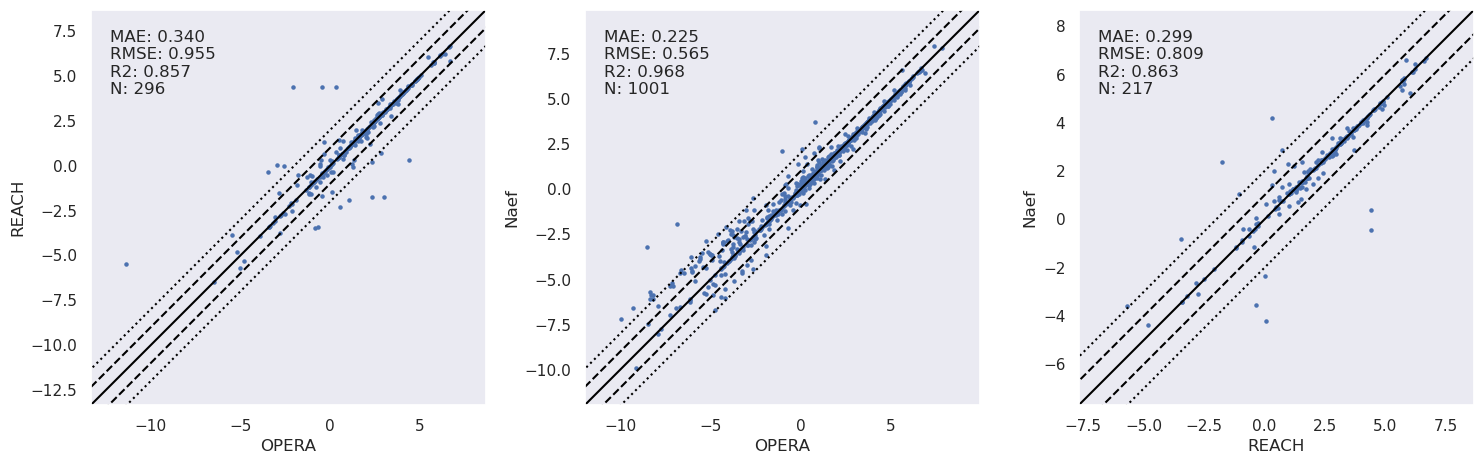

In [100]:
df_combined = pd.concat([df_Shuzhe_compact, df_opera_compact, df_reach_semi_curated_exp_compact, df_naef_acree_compact], ignore_index=True)
#for the seperate datasets: drop duplicates and make a new combination
df_Shuzhe_compact_unique = df_Shuzhe_compact.drop_duplicates(subset=['inchikey'])
df_opera_compact_unique = df_opera_compact.drop_duplicates(subset=['inchikey'])
df_reach_semi_curated_exp_compact_unique = df_reach_semi_curated_exp_compact.drop_duplicates(subset=['inchikey'])
df_naef_acree_compact_unique = df_naef_acree_compact.drop_duplicates(subset=['inchikey'])
df_combined_unique_per_set = pd.concat([df_Shuzhe_compact_unique, df_opera_compact_unique, df_reach_semi_curated_exp_compact_unique, df_naef_acree_compact_unique], ignore_index=True)

df_combined_unique_per_set_no_shuze = df_combined_unique_per_set.loc[df_combined_unique_per_set['source'] != 'Shuzhe']
#now: for each possible combination between the sources, do correlation plot of log10_VP_Pa
#first, get all unique combinations of sources
sources = df_combined_unique_per_set_no_shuze['source'].unique()
combinations = []
for i in range(len(sources)):
    for j in range(i+1, len(sources)):
        combinations.append([sources[i], sources[j]])

#make len(combinations) subplots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
for row, combination in enumerate(combinations):

    df_subset = df_combined_unique_per_set_no_shuze.loc[df_combined_unique_per_set_no_shuze['source'].isin(combination)]
    #get the duplicates
    df_subset_duplicates = df_subset[df_subset.duplicated(subset=['inchikey'], keep=False)]
    #plot the duplicates: source 1 on x-axis, source 2 on y-axis
    df_subset_duplicates_source1 = df_subset_duplicates.loc[df_subset_duplicates['source'] == combination[0]]
    df_subset_duplicates_source2 = df_subset_duplicates.loc[df_subset_duplicates['source'] == combination[1]]
    #sort both by inchikey to have the same order
    df_subset_duplicates_source1 = df_subset_duplicates_source1.sort_values(by='inchikey')
    df_subset_duplicates_source2 = df_subset_duplicates_source2.sort_values(by='inchikey')
    minimum = min(df_subset_duplicates_source1['log10_VP_Pa'].min(), df_subset_duplicates_source2['log10_VP_Pa'].min())
    maximum = max(df_subset_duplicates_source1['log10_VP_Pa'].max(), df_subset_duplicates_source2['log10_VP_Pa'].max())
    #add subplot of correlation plot
    
    axs[row].scatter(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'], s=5)
    axs[row].set_xlabel(combination[0])
    axs[row].set_ylabel(combination[1])
    #make square
    axs[row].set_aspect('equal', 'box')
    #add diagonal line
    axs[row].plot([-20, 10], [-20, 10], color='black')
    #add dashed lines at 1 log unit difference
    axs[row].plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
    axs[row].plot([-21, 9], [-20, 10], color='black', linestyle='dashed')
    #add dashed lines at 2 log unit difference
    axs[row].plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
    axs[row].plot([-22, 8], [-20, 10], color='black', linestyle='dotted')
    #add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np
    from scipy.stats import pearsonr, spearmanr, kendalltau
    #remove nan values
    df_subset_duplicates_source1 = df_subset_duplicates_source1.dropna()
    df_subset_duplicates_source2 = df_subset_duplicates_source2.dropna()
    #calculate metrics
    mae = mean_absolute_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    rmse = np.sqrt(mean_squared_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa']))
    r2 = r2_score(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    pearson = pearsonr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    spearman = spearmanr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    kendall = kendalltau(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    #add metrics and number of points to plot
    axs[row].text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {}'.format(mae, rmse, r2, len(df_subset_duplicates_source1)), transform=axs[row].transAxes, verticalalignment='top')
    axs[row].grid()
    #set limit
    axs[row].set_xlim(minimum-2, maximum+2)
    axs[row].set_ylim(minimum-2, maximum+2)
#add overall title
# fig.suptitle('Correlation plots of log10_VP_Pa between different sources')

plt.tight_layout()

plt.show()



Amount of inchikeys with a difference of 2 or more: 128


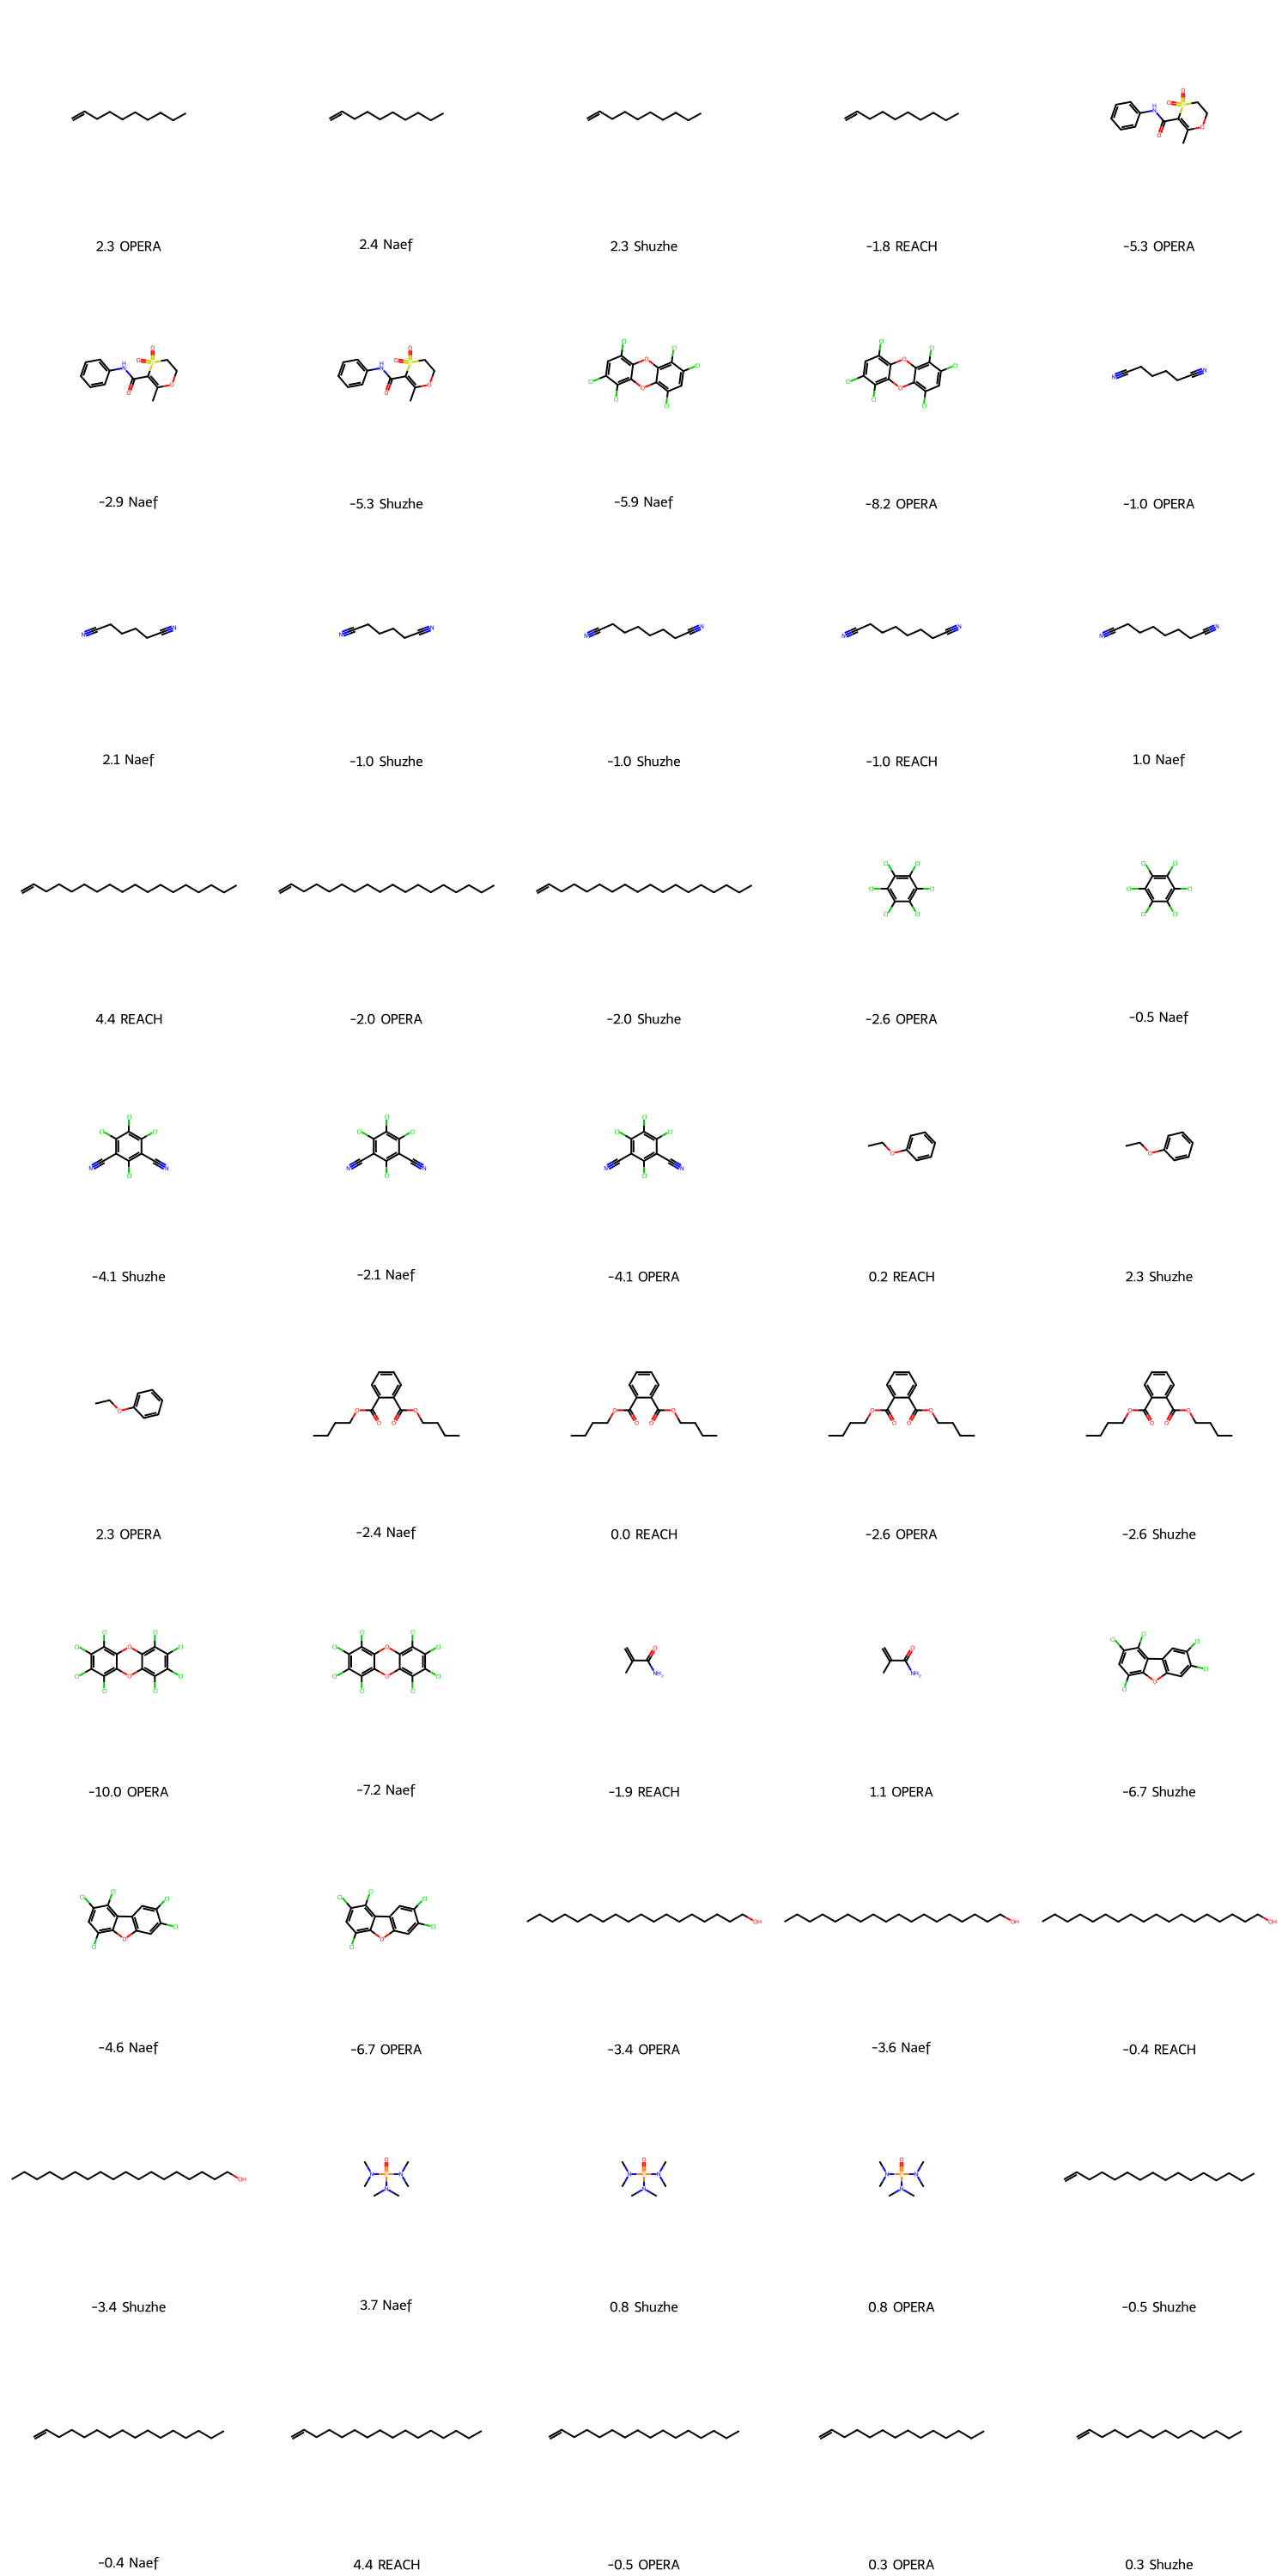

In [78]:
#get all the points that have a diff between max an min of 2 log units or more.
#for this, we can get the duplicate inchis, iterate over them and pull the min and max value. If the difference is 2 or more, add to a list

#first, get all the duplicates
df_duplicates = df_combined_unique_per_set[df_combined_unique_per_set.duplicated(subset=['inchikey'], keep=False)]
#now, iterate over them
inchikeys = df_duplicates['inchikey'].unique()
inchikeys_with_diff = []
for inchikey in inchikeys:
    df_subset = df_duplicates.loc[df_duplicates['inchikey'] == inchikey]
    minimum = df_subset['log10_VP_Pa'].min()
    maximum = df_subset['log10_VP_Pa'].max()
    if maximum-minimum >= 2:
        inchikeys_with_diff.append(inchikey)
#now make a df with these
df_inchikeys_with_diff = df_duplicates.loc[df_duplicates['inchikey'].isin(inchikeys_with_diff)]
#sor tby inchikey
df_inchikeys_with_diff = df_inchikeys_with_diff.sort_values(by='inchikey')
#get the smiles and vapor pressures
smiles = df_inchikeys_with_diff['standardized_smiles'].tolist()
log10_VP_Pa = df_inchikeys_with_diff['log10_VP_Pa'].tolist()
#print amount, draw first 50 with vapor pressure (rounded to 1 decimal) and source as legend
print('Amount of inchikeys with a difference of 2 or more: {}'.format(len(smiles)))
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor

mols = [Chem.MolFromSmiles(smile) for smile in smiles]
#add the vapor pressure as a property
for i, mol in enumerate(mols):
    mol.SetProp('log10_VP_Pa', str(round(log10_VP_Pa[i], 1)))
#add the source as a property
sources = df_inchikeys_with_diff['source'].tolist()
for i, mol in enumerate(mols):
    mol.SetProp('source', sources[i])
#draw the first 50
Draw.MolsToGridImage(mols[:50], molsPerRow=5, subImgSize=(300, 300), legends=[mol.GetProp('log10_VP_Pa') + ' ' + mol.GetProp('source') for mol in mols[:50]])

Index(['Unnamed: 0', 'Factsheet_ID', 'Substance_ID', 'Substance_Name', 'EC_No',
       'CAS_RN', 'Entry in ECHA DB correct?', 'Substance Type', 'Composition',
       'Substance_Physical_State', 'Registration_status', 'Registration_Type',
       'Tonnage_Band_Displayed', 'Molecular_Formula',
       'SMILES according to CAS RN', 'pV [Pa] 25 °C', 'log10 KAW 25 °C',
       'SW [mg/l] 25 °C', 'log10 KOW 25 °C', 'Tb [°C]', 'kOH [cm3/s] 25 °C',
       'HO [bar] 25 °C', 'log10 KOC 25 °C', 'pV [Pa] 20 °C', 'log10 KAW 20 °C',
       'SW [mg/l] 20 °C', 'log10 KOW 20 °C', 'HO [bar] 20 °C',
       'log10 KOA 20 °C', 'Different SMILES at pH 7.4', '#name', 'iupacName',
       'P (upperQualifier)', 'P (upperValue)', 'P (lowerQualifier)',
       'P (lowerValue)', 'P (unit)', 'T (upperQualifier)', 'T (upperValue)',
       'T (lowerQualifier)', 'T (lowerValue)', 'T (unit)', 'VP_Pa',
       'Temperature_K', 'SMILES', 'standardized_smiles', 'log10_VP_Pa',
       'NumHeavyAtoms'],
      dtype='object')


/tmp/ipykernel_16747/1778718590.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reach_exp_compact['inchikey'] = df_reach_exp_compact['standardized_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))


Amount of rows: 1425
Amount of unique inchikeys: 803


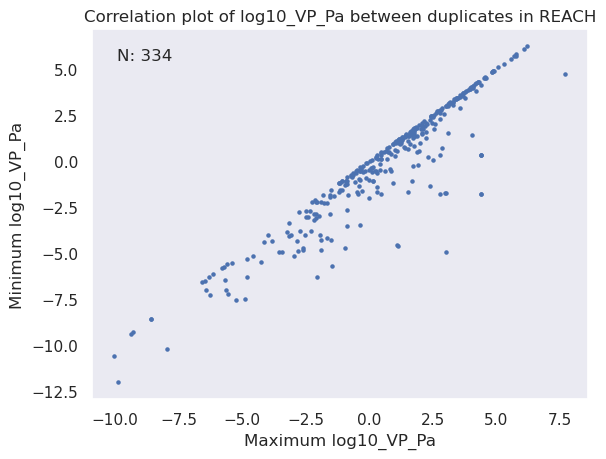

In [87]:
#wait, can we get the REACH set in a different way? Because should have overlap of 850 between physprop and REACH.
#lets look at this combining and backtracking again.
df_cosmo_reach = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/REACH/REACH_paper_curation_cosmo_vals.csv')
df_reach_standardized_uncurated = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/REACH_standardized_not_cleaned.csv')
#get only Temperature_K = 298.15
df_reach_standardized_uncurated_298 = df_reach_standardized_uncurated.loc[df_reach_standardized_uncurated['Temperature_K'] == 298.15]
df_reach_standardized_uncurated_298 = df_reach_standardized_uncurated_298.rename(columns={'cas':'CAS_RN'})
df_reach_cosmotherm_curated_merged = df_cosmo_reach.merge(df_reach_standardized_uncurated_298, on='CAS_RN')
df_reach_cosmotherm_curated_merged
#print the columns
print(df_reach_cosmotherm_curated_merged.columns)
#get only columns: standardized_smiles and log10_VP_Pa
df_reach_exp_compact = df_reach_cosmotherm_curated_merged[['standardized_smiles', 'log10_VP_Pa']]
df_reach_exp_compact['inchikey'] = df_reach_exp_compact['standardized_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))
df_reach_exp_compact
#print len and number of unique inchikeys
print('Amount of rows: {}'.format(len(df_reach_exp_compact)))
print('Amount of unique inchikeys: {}'.format(len(df_reach_exp_compact['inchikey'].unique())))
#do correllation plot of the log10_VP_Pa for duplicates: x axis max, y axis min for each inchikey (if more then 1)
#first, get all the duplicates
df_duplicates = df_reach_exp_compact[df_reach_exp_compact.duplicated(subset=['inchikey'], keep=False)]
#now, iterate over them
inchikeys = df_duplicates['inchikey'].unique()
maxes,mines = [],[]
for inchikey in inchikeys:
    df_subset = df_duplicates.loc[df_duplicates['inchikey'] == inchikey]
    minimum = df_subset['log10_VP_Pa'].min()
    maximum = df_subset['log10_VP_Pa'].max()
    maxes.append(maximum)
    mines.append(minimum)
#make scatter plot
plt.scatter(maxes, mines, s=5)
plt.xlabel('Maximum log10_VP_Pa')
plt.ylabel('Minimum log10_VP_Pa')
plt.title('Correlation plot of log10_VP_Pa between duplicates in REACH')
#text: number of datapoints
plt.text(0.05, 0.95, 'N: {}'.format(len(maxes)), transform=plt.gca().transAxes, verticalalignment='top')
plt.grid()
plt.show()
    


In [91]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
df_cosmo_reach['standardized_smiles'] = df_cosmo_reach.apply(lambda row: Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles((row['SMILES according to CAS RN'])))), axis=1)
df_cosmo_reach['inchikey'] = df_cosmo_reach['standardized_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))
df_cosmo_reach
#merge with combined_df on inchikey
df_cosmo_reach_merged = df_cosmo_reach.merge(df_combined, on='inchikey')
df_cosmo_reach_merged

,Unnamed: 0,Factsheet_ID,Substance_ID,Substance_Name,EC_No,CAS_RN,Entry in ECHA DB correct?,Substance Type,Composition,Substance_Physical_State,...,SW [mg/l] 20 °C,log10 KOW 20 °C,HO [bar] 20 °C,log10 KOA 20 °C,Different SMILES at pH 7.4,standardized_smiles_x,inchikey,standardized_smiles_y,log10_VP_Pa,source
0,116,10188,100.035.886,1-(3-sulphonatopropyl)pyridinium,239-491-3,15471-17-7,yes,organic,mono-constituent substance,solid,...,miscible,-7.861149,1.009000e-17,19.184235,False,O=S(=O)([O-])CCC[n+]1ccccc1,REEBJQTUIJTGAL-UHFFFAOYSA-N,O=S(=O)([O-])CCC[n+]1ccccc1,-4.372634,REACH
1,116,10188,100.035.886,1-(3-sulphonatopropyl)pyridinium,239-491-3,15471-17-7,yes,organic,mono-constituent substance,solid,...,miscible,-7.861149,1.009000e-17,19.184235,False,O=S(=O)([O-])CCC[n+]1ccccc1,REEBJQTUIJTGAL-UHFFFAOYSA-N,O=S(=O)([O-])CCC[n+]1ccccc1,-2.617983,REACH
2,116,10188,100.035.886,1-(3-sulphonatopropyl)pyridinium,239-491-3,15471-17-7,yes,organic,mono-constituent substance,solid,...,miscible,-7.861149,1.009000e-17,19.184235,False,O=S(=O)([O-])CCC[n+]1ccccc1,REEBJQTUIJTGAL-UHFFFAOYSA-N,O=S(=O)([O-])CCC[n+]1ccccc1,-4.841638,REACH
3,139,22813,100.100.553,6'-(dibutylamino)-3'-methyl-2'-(phenylamino)sp...,403-830-5,89331-94-2,Omitted undefined stereo in OpenBabel,organic,mono-constituent substance,solid,...,2.331901e-06,9.540983,7.518800e-20,21.311978,False,CCCCN(CCCC)c1ccc2c(c1)Oc1cc(C)c(Nc3ccccc3)cc1C...,XAAILNNJDMIMON-UHFFFAOYSA-N,CCCCN(CCCC)c1ccc2c(c1)Oc1cc(C)c(Nc3ccccc3)cc1C...,-6.567031,Shuzhe
4,217,6884,100.110.083,"2-Pyridinecarboxamide, 4-[4-[[[[4-chloro-3-(tr...",608-209-4,284461-73-0,yes,organic,mono-constituent substance,solid,...,0.5308391,5.568499,1.726700e-19,20.950909,False,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,MLDQJTXFUGDVEO-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,-10.387216,Shuzhe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3114,4390,21573,100.000.815,Carbon tetrafluoride,200-896-5,75-73-0,yes,organic,mono-constituent substance,gaseous,...,2153.029,1.697105,4.546394e+02,-0.469541,False,FC(F)(F)F,TXEYQDLBPFQVAA-UHFFFAOYSA-N,FC(F)(F)F,7.367927,OPERA
3115,4390,21573,100.000.815,Carbon tetrafluoride,200-896-5,75-73-0,yes,organic,mono-constituent substance,gaseous,...,2153.029,1.697105,4.546394e+02,-0.469541,False,FC(F)(F)F,TXEYQDLBPFQVAA-UHFFFAOYSA-N,FC(F)(F)F,7.910000,Naef
3116,4391,14250,100.000.739,Methane,200-812-7,74-82-8,yes,organic,mono-constituent substance,gaseous,...,9615.968,0.904794,1.693928e+02,-0.040769,False,C,VNWKTOKETHGBQD-UHFFFAOYSA-N,C,7.793088,Shuzhe
3117,4391,14250,100.000.739,Methane,200-812-7,74-82-8,yes,organic,mono-constituent substance,gaseous,...,9615.968,0.904794,1.693928e+02,-0.040769,False,C,VNWKTOKETHGBQD-UHFFFAOYSA-N,C,7.793102,OPERA


In [92]:
df_cosmo_reach_merged['source'].value_counts()

source
REACH     1173
Shuzhe     849
OPERA      647
Naef       450
Name: count, dtype: int64

In [107]:
df_reach_standardized_uncurated_298['inchikey'] = df_reach_standardized_uncurated_298['standardized_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))
df_cosmo_reach['inchikey'].isin(df_reach_standardized_uncurated_298['inchikey']).value_counts()

inchikey
False    3611
True      781
Name: count, dtype: int64

In [116]:
#read in ../tmp_data/df_original_shuze_standardized_298.csv
df_shhuzhe = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/df_original_shuze_standardized_298.csv')
df_shhuzhe['inchikey'] = df_shhuzhe['standardized_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))
#get df_shhuzhe_reach, where 'REACH' is in string source
df_shhuzhe_reach = df_shhuzhe.loc[df_shhuzhe['Source'].str.contains('REACH')]
df_shhuzhe_reach
#get compact version with standardized_smiles, log10_VP_Pa and inchikey
df_shhuzhe_reach_compact = df_shhuzhe_reach[['standardized_smiles', 'VP_logPA_shuze', 'inchikey']]
df_shhuzhe_reach_compact
#check how many of these match to: df_cosmo_reach and df_reach_standardized_uncurated_298
df_shhuzhe_reach_compact['inchikey'].isin(df_cosmo_reach['inchikey']).value_counts()
df_shhuzhe_reach_compact['inchikey'].isin(df_reach_standardized_uncurated_298['inchikey']).value_counts()

inchikey
True     843
False      3
Name: count, dtype: int64

Amount of rows before dropping duplicates: 843
Amount of rows after dropping duplicates: 843
Amount of rows before dropping duplicates: 843
Amount of rows after dropping duplicates: 843


Text(0.5, 1.0, 'Correlation plot of log10_VP_Pa between Shuzhe and REACH')

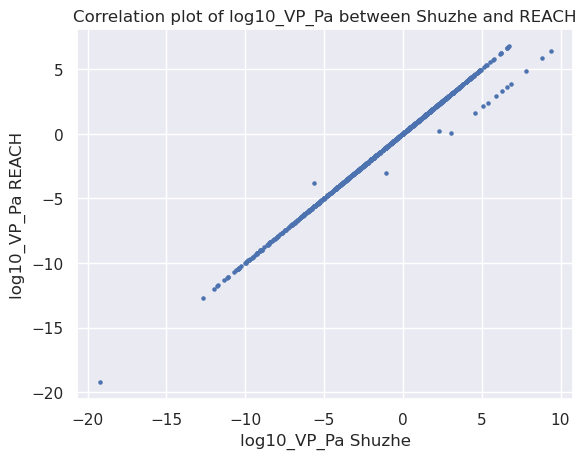

In [120]:
#do correlation between log10_VP_Pa of df_shhuzhe_reach_compact and df_reach_standardized_uncurated_298.
df_shhuzhe_reach_compact = df_shhuzhe_reach_compact.rename(columns={'VP_logPA_shuze': 'log10_VP_Pa'})
#get only inchikeys that are in df_reach_standardized_uncurated_298
df_shhuzhe_reach_compact_overlap = df_shhuzhe_reach_compact.loc[df_shhuzhe_reach_compact['inchikey'].isin(df_reach_standardized_uncurated_298['inchikey'])]
#and vice_versa
df_reach_standardized_uncurated_298_overlap = df_reach_standardized_uncurated_298.loc[df_reach_standardized_uncurated_298['inchikey'].isin(df_shhuzhe_reach_compact['inchikey'])]

#drop duplicates for both, and print out how many are dropped and left
print('Amount of rows before dropping duplicates: {}'.format(len(df_shhuzhe_reach_compact_overlap)))
df_shhuzhe_reach_compact_overlap = df_shhuzhe_reach_compact_overlap.drop_duplicates(subset=['inchikey'])
print('Amount of rows after dropping duplicates: {}'.format(len(df_shhuzhe_reach_compact_overlap)))

print('Amount of rows before dropping duplicates: {}'.format(len(df_reach_standardized_uncurated_298_overlap)))
df_reach_standardized_uncurated_298_overlap = df_reach_standardized_uncurated_298_overlap.drop_duplicates(subset=['inchikey'])
print('Amount of rows after dropping duplicates: {}'.format(len(df_reach_standardized_uncurated_298_overlap)))

#sort both by inchikey to have the same order
df_shhuzhe_reach_compact_overlap = df_shhuzhe_reach_compact_overlap.sort_values(by='inchikey')
df_reach_standardized_uncurated_298_overlap = df_reach_standardized_uncurated_298_overlap.sort_values(by='inchikey')
#plot 
plt.scatter(df_shhuzhe_reach_compact_overlap['log10_VP_Pa'], df_reach_standardized_uncurated_298_overlap['log10_VP_Pa'], s=5)
plt.xlabel('log10_VP_Pa Shuzhe')
plt.ylabel('log10_VP_Pa REACH')
plt.title('Correlation plot of log10_VP_Pa between Shuzhe and REACH')
#seems like there are some unit conversion issues for a handful of datapoints

/tmp/ipykernel_16747/1675945617.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reach_all_compact['inchikey'] = df_reach_all_compact['standardized_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))


1408


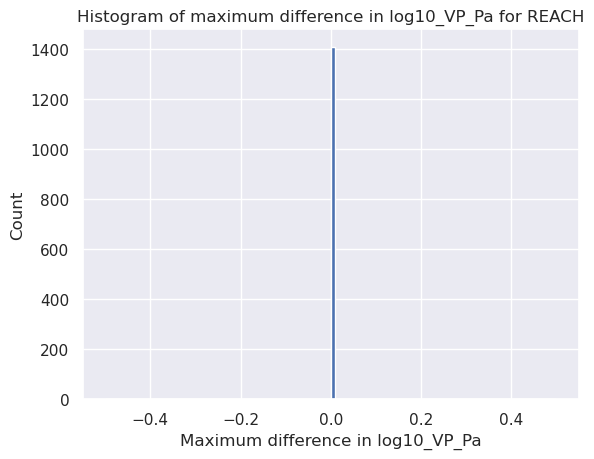

In [155]:
#wait, maybe we can get REACH with three levels: 1. REACH everything, 2. REACH that are in the COSMO-RS paper, 3. REACH that are in the COSMO-RS paper and have a vapor pressure measurement
df_reach_standardized_uncurated_298
df_reach_all_compact = df_reach_standardized_uncurated_298[['standardized_smiles', 'log10_VP_Pa']]
df_reach_all_compact['inchikey'] = df_reach_all_compact['standardized_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))
df_reach_all_compact
#get all unique inchis
inchikeys_reach_all = df_reach_all_compact['inchikey'].unique()
means,max_diffs ,smiles = [],[],[]
for inchikey in inchikeys_reach_all:
    df_subset = df_reach_all_compact.loc[df_reach_all_compact['inchikey'] == inchikey]
    means.append(df_subset['log10_VP_Pa'].mean())
    max_diff = df_subset['log10_VP_Pa'].max() - df_subset['log10_VP_Pa'].min()
    max_diffs.append(max_diff)
    #get the smiles
    smiles.append(df_subset['standardized_smiles'].iloc[0])

#make df with these
df_reach_all_compact_unique = pd.DataFrame({'inchikey': inchikeys_reach_all, 'mean_log10_VP_Pa': means, 'max_diff_log10_VP_Pa': max_diffs, 'standardized_smiles': smiles})
print(len(df_reach_all_compact_unique))
#histogram of max difs
plt.hist(df_reach_all_compact_unique['max_diff_log10_VP_Pa'], bins=100)
plt.xlabel('Maximum difference in log10_VP_Pa')
plt.ylabel('Count')
plt.title('Histogram of maximum difference in log10_VP_Pa for REACH')
plt.show()

In [147]:
#can we link these back to the cosmoRS paper?
df_cosmo_reach = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/REACH/REACH_paper_curation_cosmo_vals.csv')
df_cosmo_reach['standardized_smiles'] = df_cosmo_reach.apply(lambda row: Chem.MolToSmiles(rdMolStandardize.ChargeParent(Chem.MolFromSmiles((row['SMILES according to CAS RN'])))), axis=1)
df_cosmo_reach['inchikey'] = df_cosmo_reach['standardized_smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)))
# df_cosmo_reach_overlap = df_cosmo_reach.loc[df_cosmo_reach['inchikey'].isin(df_reach_all_compact_unique['inchikey'])]
#merge on inchikey
df_cosmo_reach_merged = df_cosmo_reach.merge(df_reach_all_compact_unique, on='inchikey')
print(len(df_cosmo_reach_merged))

781


In [149]:
df_cosmo_reach_overlap_max_cur = df_cosmo_reach_merged.copy()
df_cosmo_reach_overlap_max_cur = df_cosmo_reach_overlap_max_cur[df_cosmo_reach_overlap_max_cur['Substance Type']=='organic']
df_cosmo_reach_overlap_max_cur = df_cosmo_reach_overlap_max_cur[df_cosmo_reach_overlap_max_cur['Composition']=='mono-constituent substance']
df_cosmo_reach_overlap_max_cur = df_cosmo_reach_overlap_max_cur[df_cosmo_reach_overlap_max_cur['pV [Pa] 25 °C'].notna()]
df_cosmo_reach_overlap_max_cur = df_cosmo_reach_overlap_max_cur[df_cosmo_reach_overlap_max_cur['Different SMILES at pH 7.4']==False]
df_cosmo_reach_overlap_max_cur = df_cosmo_reach_overlap_max_cur[df_cosmo_reach_overlap_max_cur['Entry in ECHA DB correct?']=='yes']
df_cosmo_reach_overlap_max_cur = df_cosmo_reach_overlap_max_cur[df_cosmo_reach_overlap_max_cur['Registration_Type']=='FULL']
df_cosmo_reach_overlap_max_cur = df_cosmo_reach_overlap_max_cur[df_cosmo_reach_overlap_max_cur['Registration_status']=='Active']
print(len(df_cosmo_reach_overlap_max_cur))

620


In [161]:
#now, make these three compact,  add source, combine with naef and opera, and do the correlation plots like before. Rows are different levels of REACH curation
df_reach_all_compact_unique['source'] = 'REACH_all'
df_cosmo_reach_merged['source'] = 'REACH_with_link_to_cosmo_paper'
df_cosmo_reach_overlap_max_cur['source'] = 'REACH_with_link_to_cosmo_paper_criteria'
df_cosmo_reach_overlap_compact = df_cosmo_reach_merged[['standardized_smiles', 'log10_VP_Pa', 'inchikey', 'source']]
df_cosmo_reach_overlap_max_cur_compact = df_cosmo_reach_overlap_max_cur[['standardized_smiles', 'log10_VP_Pa', 'inchikey', 'source']]
df_reach_all_compact_unique['log10_VP_Pa'] = df_reach_all_compact_unique['mean_log10_VP_Pa']
df_reach_all_compact_unique = df_reach_all_compact_unique[['standardized_smiles', 'log10_VP_Pa', 'inchikey', 'source']]

KeyError: 'mean_log10_VP_Pa'

In [162]:
#remove duplicates on inchikey
df_reach_all_compact_unique = df_reach_all_compact_unique.drop_duplicates(subset=['inchikey'])
df_cosmo_reach_overlap_compact = df_cosmo_reach_overlap_compact.drop_duplicates(subset=['inchikey'])
df_cosmo_reach_overlap_max_cur_compact = df_cosmo_reach_overlap_max_cur_compact.drop_duplicates(subset=['inchikey'])
df_combined = pd.concat([df_reach_all_compact_unique,df_cosmo_reach_overlap_compact,df_cosmo_reach_overlap_max_cur_compact, df_opera_compact, df_naef_acree_compact], ignore_index=True)

476 476
315 315
327 327
221 221
291 291
216 216


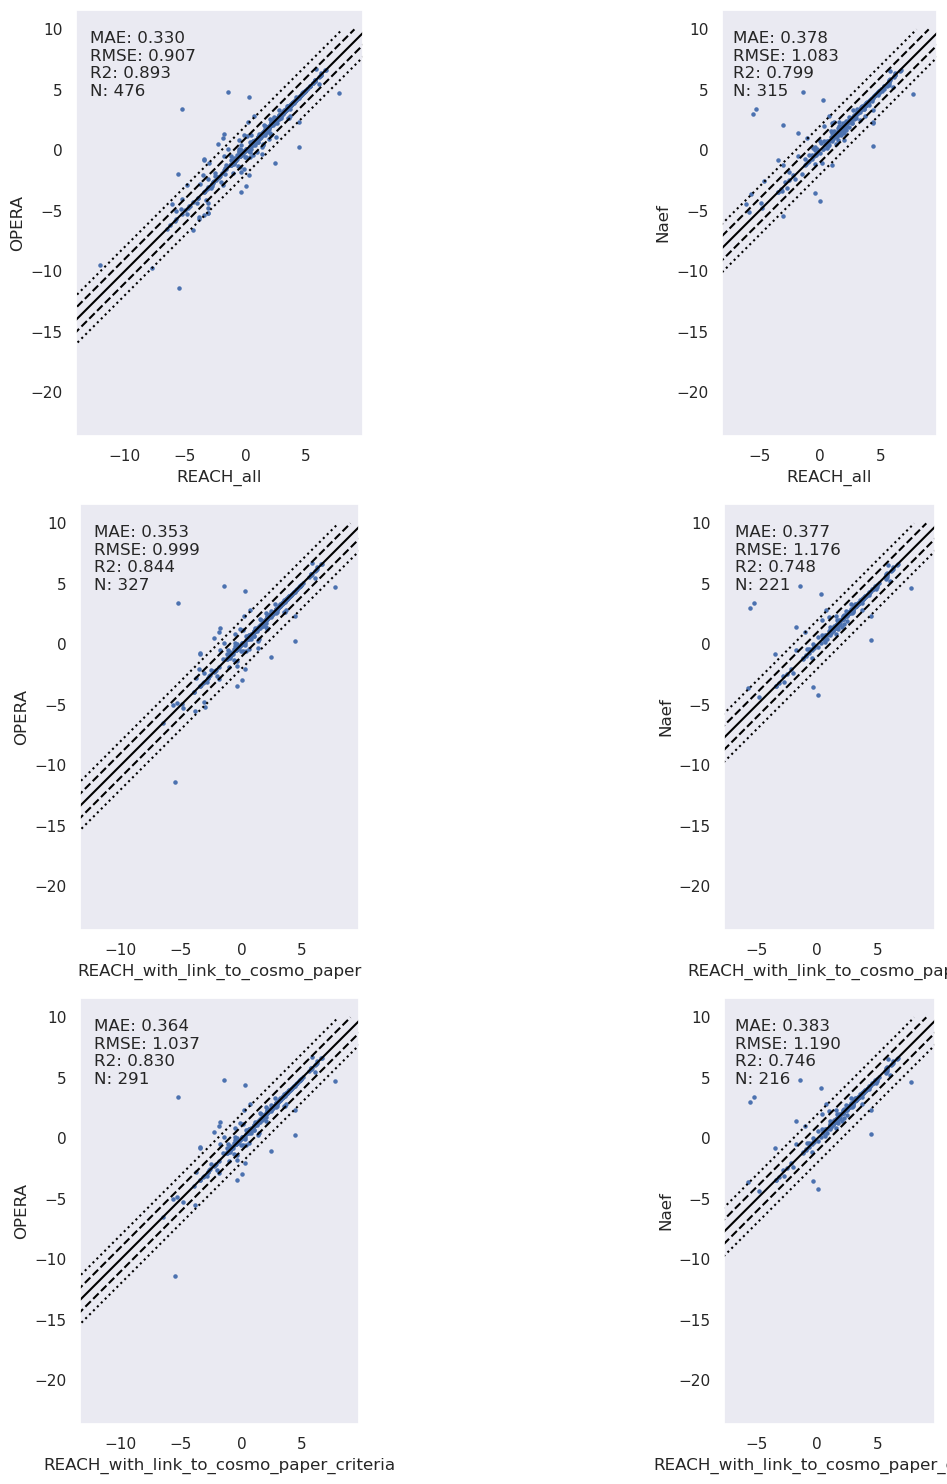

In [172]:
#make 3x2 plot like before: 1. REACH_all vs opera, 2. REACH_all vs naef, 3. REACH_with_link_to_cosmo_paper vs opera, 4. REACH_with_link_to_cosmo_paper vs naef, 5. REACH_with_link_to_cosmo_paper_criteria vs opera, 6. REACH_with_link_to_cosmo_paper_criteria vs naef

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
combination_list = [['REACH_all', 'OPERA'], ['REACH_all', 'Naef'], ['REACH_with_link_to_cosmo_paper', 'OPERA'], ['REACH_with_link_to_cosmo_paper', 'Naef'], ['REACH_with_link_to_cosmo_paper_criteria', 'OPERA'], ['REACH_with_link_to_cosmo_paper_criteria', 'Naef']]
for i, combination in enumerate(combination_list):
    #get plot coordinate (row, column)
    row = i // 2
    column = i % 2

    df_subset = df_combined.loc[df_combined['source'].isin(combination)]
    if len(df_subset) == 0:
        continue
    #get the duplicates
    df_subset_duplicates = df_subset[df_subset.duplicated(subset=['inchikey'], keep=False)]
    #plot the duplicates: source 1 on x-axis, source 2 on y-axis
    df_subset_duplicates_source1 = df_subset_duplicates.loc[df_subset_duplicates['source'] == combination[0]]
    df_subset_duplicates_source2 = df_subset_duplicates.loc[df_subset_duplicates['source'] == combination[1]]

    #drop duplicates
    df_subset_duplicates_source1 = df_subset_duplicates_source1.drop_duplicates(subset=['inchikey'])
    df_subset_duplicates_source2 = df_subset_duplicates_source2.drop_duplicates(subset=['inchikey'])
    #drop nans
    df_subset_duplicates_source1 = df_subset_duplicates_source1.dropna()
    df_subset_duplicates_source2 = df_subset_duplicates_source2.dropna()

    #get only overlap
    df_subset_duplicates_source1 = df_subset_duplicates_source1.loc[df_subset_duplicates_source1['inchikey'].isin(df_subset_duplicates_source2['inchikey'])]
    df_subset_duplicates_source2 = df_subset_duplicates_source2.loc[df_subset_duplicates_source2['inchikey'].isin(df_subset_duplicates_source1['inchikey'])]


    print(len(df_subset_duplicates_source1), len(df_subset_duplicates_source2))
    #sort both by inchikey to have the same order
    df_subset_duplicates_source1 = df_subset_duplicates_source1.sort_values(by='inchikey')
    df_subset_duplicates_source2 = df_subset_duplicates_source2.sort_values(by='inchikey')
    minimum = min(df_subset_duplicates_source1['log10_VP_Pa'].min(), df_subset_duplicates_source2['log10_VP_Pa'].min())
    maximum = max(df_subset_duplicates_source1['log10_VP_Pa'].max(), df_subset_duplicates_source2['log10_VP_Pa'].max())
    #add subplot of correlation plot
    
    axs[row, column].scatter(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'], s=5)
    axs[row, column].set_xlabel(combination[0])
    axs[row, column].set_ylabel(combination[1])
    #make square
    axs[row, column].set_aspect('equal', 'box')
    #add diagonal line
    axs[row, column].plot([-20, 10], [-20, 10], color='black')
    #add dashed lines at 1 log unit difference
    axs[row, column].plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
    axs[row, column].plot([-21, 9], [-20, 10], color='black', linestyle='dashed')
    #add dashed lines at 2 log unit difference
    axs[row, column].plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
    axs[row, column].plot([-22, 8], [-20, 10], color='black', linestyle='dotted')
    #add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np
    from scipy.stats import pearsonr, spearmanr, kendalltau
    #remove nan values
    df_subset_duplicates_source1 = df_subset_duplicates_source1.dropna()
    df_subset_duplicates_source2 = df_subset_duplicates_source2.dropna()
    #calculate metrics
    mae = mean_absolute_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    rmse = np.sqrt(mean_squared_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa']))
    r2 = r2_score(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    pearson = pearsonr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    spearman = spearmanr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    kendall = kendalltau(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
    #add metrics and number of points to plot
    axs[row, column].text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {}'.format(mae, rmse, r2, len(df_subset_duplicates_source1)), transform=axs[row, column].transAxes, verticalalignment='top')
    axs[row, column].grid()
    #set limit
    axs[row, column].set_xlim(minimum-2, maximum+2)
#add overall title
# fig.suptitle('Correlation plots of log10_VP_Pa between different sources')

plt.tight_layout()
plt.show()

In [189]:
#actually, lets look at this: from overlap between reach all and opera, show correlation between experimental and COSMO preds
# df_reach_all_compact_unique
# df_reach_cosmotherm_curated_merged
# df_reach_cosmotherm_curated_merged
# #get df_reach_cosmotherm_curated_merged where inchikey in df_reach_all_compact_unique
#get inchis with overlap between physprop and REACH_all from df_combined
inchis_reach_all = df_reach_all_compact_unique['inchikey'].unique()
inchis_physprop = df_combined[df_combined['source'] == 'OPERA']['inchikey'].unique()
#print len of overlap
print('Amount of inchikeys in REACH_all: {}'.format(len(inchis_reach_all)))
print('Amount of inchikeys in OPERA: {}'.format(len(inchis_physprop)))
print('Amount of inchikeys in both: {}'.format(len(set(inchis_reach_all).intersection(inchis_physprop))))

Amount of inchikeys in REACH_all: 1408
Amount of inchikeys in OPERA: 2368
Amount of inchikeys in both: 476


In [190]:
df_cosmo_with_experimental = df_cosmo_reach_merged.loc[df_cosmo_reach_merged['inchikey'].isin(inchis_physprop)]
df_cosmo_with_experimental
#get these inchis
overlap_inchis_reach_exp_cosmo_physprop = df_cosmo_with_experimental['inchikey'].unique()

array(['UZGLIIJVICEWHF-UHFFFAOYSA-N', 'CGSLYBDCEGBZCG-UHFFFAOYSA-N',
       'GTVWRXDRKAHEAD-UHFFFAOYSA-N', 'BJQHLKABXJIVAM-UHFFFAOYSA-N',
       'XZZNDPSIHUTMOC-UHFFFAOYSA-N', 'BTFJIXJJCSYFAL-UHFFFAOYSA-N',
       'FIQMHBFVRAXMOP-UHFFFAOYSA-N', 'VOWAEIGWURALJQ-UHFFFAOYSA-N',
       'IRIAEXORFWYRCZ-UHFFFAOYSA-N', 'GLDOVTGHNKAZLK-UHFFFAOYSA-N',
       'KUAZQDVKQLNFPE-UHFFFAOYSA-N', 'PYGXAGIECVVIOZ-UHFFFAOYSA-N',
       'QYMMJNLHFKGANY-UHFFFAOYSA-N', 'HPEUJPJOZXNMSJ-UHFFFAOYSA-N',
       'HHECSPXBQJHZAF-UHFFFAOYSA-N', 'XMTQQYYKAHVGBJ-UHFFFAOYSA-N',
       'MHKLKWCYGIBEQF-UHFFFAOYSA-N', 'XUGNVMKQXJXZCD-UHFFFAOYSA-N',
       'RQVYBGPQFYCBGX-UHFFFAOYSA-N', 'BXWNKGSJHAJOGX-UHFFFAOYSA-N',
       'DOIRQSBPFJWKBE-UHFFFAOYSA-N', 'ATGUVEKSASEFFO-UHFFFAOYSA-N',
       'GUEIZVNYDFNHJU-UHFFFAOYSA-N', 'FLIACVVOZYBSBS-UHFFFAOYSA-N',
       'QBDSZLJBMIMQRS-UHFFFAOYSA-N', 'ISAOCJYIOMOJEB-UHFFFAOYSA-N',
       'AXISYYRBXTVTFY-UHFFFAOYSA-N', 'DOOTYTYQINUNNV-UHFFFAOYSA-N',
       'MCNOFYBITGAAGM-UHFFFAOYSA-

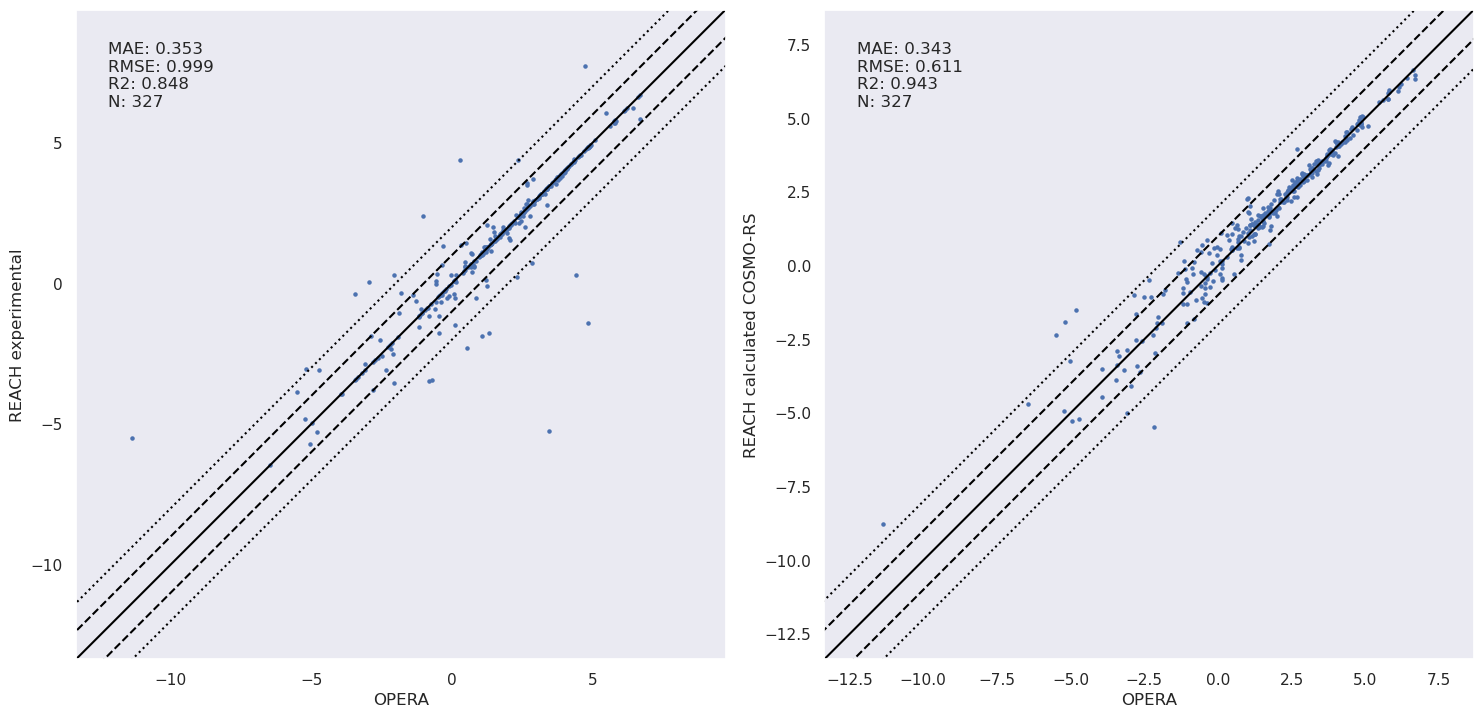

In [207]:
#for these inchis, get the values from physprops, reach and csomo
df_reach_all_compact_unique_overlap = df_reach_all_compact_unique.loc[df_reach_all_compact_unique['inchikey'].isin(overlap_inchis_reach_exp_cosmo_physprop)]
df_reach_all_compact_unique_overlap
df_cosmo_reach_merged_overlap = df_cosmo_reach_merged.loc[df_cosmo_reach_merged['inchikey'].isin(overlap_inchis_reach_exp_cosmo_physprop)]
df_cosmo_reach_merged_overlap
df_physprop_overlap = df_combined.loc[df_combined['inchikey'].isin(overlap_inchis_reach_exp_cosmo_physprop)]
df_physprop_overlap = df_physprop_overlap.loc[df_physprop_overlap['source'] == 'OPERA']
df_physprop_overlap
#plot the correlation plots side by side: x-axis physprop, y-axis pV [Pa] 25 °C or log10_VP_Pa
#for all, drop duplicates on inchikey
df_reach_all_compact_unique_overlap = df_reach_all_compact_unique_overlap.drop_duplicates(subset=['inchikey'])
df_cosmo_reach_merged_overlap = df_cosmo_reach_merged_overlap.drop_duplicates(subset=['inchikey'])
df_physprop_overlap = df_physprop_overlap.drop_duplicates(subset=['inchikey'])

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
df_subset_duplicates_source1 = df_physprop_overlap
df_subset_duplicates_source2 = df_reach_all_compact_unique_overlap
#sort both by inchikey to have the same order
df_subset_duplicates_source1 = df_subset_duplicates_source1.sort_values(by='inchikey')
df_subset_duplicates_source2 = df_subset_duplicates_source2.sort_values(by='inchikey')
minimum = min(df_subset_duplicates_source1['log10_VP_Pa'].min(), df_subset_duplicates_source2['log10_VP_Pa'].min())
maximum = max(df_subset_duplicates_source1['log10_VP_Pa'].max(), df_subset_duplicates_source2['log10_VP_Pa'].max())
#add subplot of correlation plot
axs[0].scatter(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'], s=5)
axs[0].set_xlabel('OPERA')
axs[0].set_ylabel('REACH experimental')
#make square
axs[0].set_aspect('equal', 'box')
#add diagonal line
axs[0].plot([-20, 10], [-20, 10], color='black')
#add dashed lines at 1 log unit difference
axs[0].plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
axs[0].plot([-21, 9], [-20, 10], color='black', linestyle='dashed')
#add dashed lines at 2 log unit difference
axs[0].plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
axs[0].plot([-22, 8], [-20, 10], color='black', linestyle='dotted')
#add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
#remove nan values
df_subset_duplicates_source1 = df_subset_duplicates_source1.dropna()
df_subset_duplicates_source2 = df_subset_duplicates_source2.dropna()
#calculate metrics
mae = mean_absolute_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
rmse = np.sqrt(mean_squared_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa']))
r2 = r2_score(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
pearson = pearsonr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
spearman = spearmanr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
kendall = kendalltau(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
#add metrics and number of points to plot
axs[0].text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {}'.format(mae, rmse, r2, len(df_subset_duplicates_source1)), transform=axs[0].transAxes, verticalalignment='top')
axs[0].grid()
#set limit
axs[0].set_xlim(minimum-2, maximum+2)
axs[0].set_ylim(minimum-2, maximum+2)

df_subset_duplicates_source1 = df_physprop_overlap
df_subset_duplicates_source2 = df_cosmo_reach_merged_overlap
#make column log10_VP_Pa wich is log10 of pV [Pa] 25 °C
df_subset_duplicates_source2['log10_VP_Pa'] = df_subset_duplicates_source2['pV [Pa] 25 °C'].apply(lambda x: np.log10(x))
#sort both by inchikey to have the same order
df_subset_duplicates_source1 = df_subset_duplicates_source1.sort_values(by='inchikey')
df_subset_duplicates_source2 = df_subset_duplicates_source2.sort_values(by='inchikey')
minimum = min(df_subset_duplicates_source1['log10_VP_Pa'].min(), df_subset_duplicates_source2['log10_VP_Pa'].min())
maximum = max(df_subset_duplicates_source1['log10_VP_Pa'].max(), df_subset_duplicates_source2['log10_VP_Pa'].max())
#add subplot of correlation plot
axs[1].scatter(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'], s=5)
axs[1].set_xlabel('OPERA')
axs[1].set_ylabel('REACH calculated COSMO-RS')
#make square
axs[1].set_aspect('equal', 'box')
#add diagonal line
axs[1].plot([-20, 10], [-20, 10], color='black')
#add dashed lines at 1 log unit difference
axs[1].plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
axs[1].plot([-21, 9], [-20, 10], color='black', linestyle='dashed')
#add dashed lines at 2 log unit difference
axs[1].plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
axs[1].plot([-22, 8], [-20, 10], color='black', linestyle='dotted')
#add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
#remove nan values
# df_subset_duplicates_source1 = df_subset_duplicates_source1.dropna()
# df_subset_duplicates_source2 = df_subset_duplicates_source2.dropna()
#calculate metrics
mae = mean_absolute_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
rmse = np.sqrt(mean_squared_error(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa']))
r2 = r2_score(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
pearson = pearsonr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
spearman = spearmanr(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
kendall = kendalltau(df_subset_duplicates_source1['log10_VP_Pa'], df_subset_duplicates_source2['log10_VP_Pa'])
#add metrics and number of points to plot
axs[1].text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {}'.format(mae, rmse, r2, len(df_subset_duplicates_source1)), transform=axs[1].transAxes, verticalalignment='top')
axs[1].grid()
#set limit
axs[1].set_xlim(minimum-2, maximum+2)
axs[1].set_ylim(minimum-2, maximum+2)
#add overall title
# fig.suptitle('Correlation plots of log10_VP_Pa between different sources')

plt.tight_layout()
plt.show()


In [209]:
#okay lets make a workflow somehow, checking the overlap between different sources and showing the experimental and cosmo values.
#First, lets get the four dataframes: PHYSPROP, REACH_EXP, REACH_COSMO, OPERA

In [224]:
df_Shuzhe = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/df_original_shuze_standardized_298.csv')
df_opera = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/df_25_opera_standardized.csv')
df_reach_semi_curated_exp = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/sandbox/REACH_semi_curated_features_compact_298K.csv')
df_naef_acree = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/sandbox/NAEF_features_compact_298K.csv')
df_Shuzhe = df_Shuzhe.rename(columns={'VP_logPA_shuze': 'log10_VP_Pa'})
df_opera = df_opera.rename(columns={'VP logPa': 'log10_VP_Pa'})
#for all, just get the smiles, VP and inchikeys
df_Shuzhe_compact = df_Shuzhe[['standardized_smiles', 'log10_VP_Pa', 'inchikey']]
df_opera_compact = df_opera[['standardized_smiles', 'log10_VP_Pa', 'inchikey']]
df_reach_semi_curated_exp_compact = df_reach_semi_curated_exp[['standardized_smiles', 'log10_VP_Pa', 'inchikey']]
df_naef_acree_compact = df_naef_acree[['standardized_smiles', 'log10_VP_Pa', 'inchikey']]
#add column source
df_Shuzhe_compact['source'] = 'Shuzhe'
df_opera_compact['source'] = 'OPERA'
df_naef_acree_compact['source'] = 'Naef'
df_cosmo_reach_compact = df_cosmo_reach[['standardized_smiles', 'pV [Pa] 20 °C', 'inchikey']]
df_cosmo_reach_compact['source'] = 'REACH_cosmo_paper'

#get: overlap inchikeys between df_cosmo_reach_compact,df_reach_semi_curated_exp_compact and df_opera_compact, as well as overlap between df_cosmo_reach_compact,df_reach_semi_curated_exp_compact and df_naef_acree_compact
#first: overlap between df_cosmo_reach_compact,df_reach_semi_curated_exp_compact
cosmo_inchis = df_cosmo_reach_compact['inchikey'].unique()
reach_exp_inchis = df_reach_semi_curated_exp_compact['inchikey'].unique()
opera_inchis = df_opera_compact['inchikey'].unique()
naef_inchis = df_naef_acree_compact['inchikey'].unique()

overlap_cosmo_reach = set(cosmo_inchis).intersection(reach_exp_inchis)
overlap_cosmo_reach_opera = set(overlap_cosmo_reach).intersection(opera_inchis)
overlap_cosmo_reach_naef = set(overlap_cosmo_reach).intersection(naef_inchis)

#get vp values for these. make 2x2 plot: 1. REACH_exp vs OPERA, 3. REACH_exp vs Naef, 2. REACH_cosmo vs OPERA, 4. REACH_cosmo vs Naef
#first, get the values
df_reach_exp_overlap = df_reach_semi_curated_exp_compact[df_reach_semi_curated_exp_compact['inchikey'].isin(overlap_cosmo_reach)]
df_reach_exp_overlap = df_reach_exp_overlap.drop_duplicates(subset=['inchikey'])
df_reach_exp_overlap = df_reach_exp_overlap.dropna()
df_reach_exp_overlap = df_reach_exp_overlap.sort_values(by='inchikey')

df_reach_cosmo_overlap = df_cosmo_reach_compact[df_cosmo_reach_compact['inchikey'].isin(overlap_cosmo_reach)]
df_reach_cosmo_overlap = df_reach_cosmo_overlap.drop_duplicates(subset=['inchikey'])
df_reach_cosmo_overlap = df_reach_cosmo_overlap.dropna()
df_reach_cosmo_overlap = df_reach_cosmo_overlap.sort_values(by='inchikey')

df_opera_overlap = df_opera_compact[df_opera_compact['inchikey'].isin(overlap_cosmo_reach)
df_opera_overlap = df_opera_overlap.drop_duplicates(subset=['inchikey'])
df_opera_overlap = df_opera_overlap.dropna()
df_opera_overlap = df_opera_overlap.sort_values(by='inchikey')

df_naef_overlap = df_naef_acree_compact[df_naef_acree_compact['inchikey'].isin(overlap_cosmo_reach)]
df_naef_overlap = df_naef_overlap.drop_duplicates(subset=['inchikey'])
df_naef_overlap = df_naef_overlap.dropna()
df_naef_overlap = df_naef_overlap.sort_values(by='inchikey')

#print the lens
print('REACH_exp: {}'.format(len(df_reach_exp_overlap)))
print('REACH_cosmo: {}'.format(len(df_reach_cosmo_overlap)))
print('OPERA: {}'.format(len(df_opera_overlap)))
print('Naef: {}'.format(len(df_naef_overlap)))

#make 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
#plot 1
axs[0, 0].scatter(df_reach_exp_overlap['log10_VP_Pa'], df_opera_overlap['log10_VP_Pa'], s=5)
axs[0, 0].set_xlabel('REACH_exp')
axs[0, 0].set_ylabel('OPERA')
#make square
axs[0, 0].set_aspect('equal', 'box')
#add diagonal line
axs[0, 0].plot([-20, 10], [-20, 10], color='black')
#add dashed lines at 1 log unit difference
axs[0, 0].plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
axs[0, 0].plot([-21, 9], [-20, 10], color='black', linestyle='dashed')
#add dashed lines at 2 log unit difference
axs[0, 0].plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
axs[0, 0].plot([-22, 8], [-20, 10], color='black', linestyle='dotted')
#add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
#remove nan values
df_reach_exp_overlap = df_reach_exp_overlap.dropna()
df_opera_overlap = df_opera_overlap.dropna()
#calculate metrics
mae = mean_absolute_error(df_reach_exp_overlap['log10_VP_Pa'], df_opera_overlap['log10_VP_Pa'])
rmse = np.sqrt(mean_squared_error(df_reach_exp_overlap['log10_VP_Pa'], df_opera_overlap['log10_VP_Pa']))
r2 = r2_score(df_reach_exp_overlap['log10_VP_Pa'], df_opera_overlap['log10_VP_Pa'])
pearson = pearsonr(df_reach_exp_overlap['log10_VP_Pa'], df_opera_overlap['log10_VP_Pa'])
spearman = spearmanr(df_reach_exp_overlap['log10_VP_Pa'], df_opera_overlap['log10_VP_Pa'])
kendall = kendalltau(df_reach_exp_overlap['log10_VP_Pa'], df_opera_overlap['log10_VP_Pa'])
#add metrics and number of points to plot
axs[0, 0].text(0.05, 0.95, 'MAE: {:.3f}\nRMSE: {:.3f}\nR2: {:.3f}\nN: {}'.format(mae, rmse, r2, len(df_reach_exp_overlap)), transform=axs[0, 0].transAxes, verticalalignment='top')
axs[0, 0].grid()
#set limit
axs[0, 0].set_xlim(-20, 10)
axs[0, 0].set_ylim(-20, 10)

#plot 2
axs[0, 1].scatter(df_reach_exp_overlap['log10_VP_Pa'], df_naef_overlap['log10_VP_Pa'], s=5)
axs[0, 1].set_xlabel('REACH_exp')
axs[0, 1].set_ylabel('Naef')
#make square
axs[0, 1].set_aspect('equal', 'box')
#add diagonal line
axs[0, 1].plot([-20, 10], [-20, 10], color='black')
#add dashed lines at 1 log unit difference
axs[0, 1].plot([-20, 10], [-21, 9], color='black', linestyle='dashed')
axs[0, 1].plot([-21, 9], [-20, 10], color='black', linestyle='dashed')
#add dashed lines at 2 log unit difference
axs[0, 1].plot([-20, 10], [-22, 8], color='black', linestyle='dotted')
axs[0, 1].plot([-22, 8], [-20, 10], color='black', linestyle='dotted')
#add metrics: MAE, RMSE, R2, Pearson, Spearman, Kendall
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


SyntaxError: '[' was never closed (2769786489.py, line 42)